Clayton Cohn<br>
3 Mar 2021<br>

# <center>Infrrd.ai Code Challenge

---

This Jupyter notebook was created by Clayton Cohn via Google Colab for the Infrrd.ai code challenge. Below are the instructions for completing the assignment:

*The problem is an Entity Recognition problem. You have to use python and any relevant libraries to solve this, as long as you understand underlying assumptions and methods (at least on a high level) being used. The preferred solution would include a jupyter notebook with all your analysis (EDA on dataset is recommended) and experiments accompanying the submission file.*

*What are we looking for in the solution*
1. *Exploratory Data Analysis*
2. *How many solutions you can think of and why are you choosing your version of the solution*
3. *How do you come to the right metric*

I will attack this problem at the sentence or "tweet" level and use the language model [BERT](https://arxiv.org/abs/1810.04805) to perform entity recognition, which is a multi-class classification problem: each word will get tagged with either an O (not an entity) or a specific entity tag. 

This notebook is adapted from the tutorial by Tobias Sterbak: https://www.depends-on-the-definition.com/named-entity-recognition-with-bert/.

Colab requires mounting Google Drive to read in data. This should be changed if trying to access the data locally.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

DATA_PATH = "drive/My Drive/colab/infrrd/"
TRAIN_FILE = "train.txt"
TEST_FILE = "test.txt"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Cleaning

BERT does its analysis at the sentence level. This is by design, as BERT's self-attention mechanism is able to incorporate semantic meaning (through context) in its vector embeddings. As such, the dataset must first be converted from words to sentences.

The ```getDataWithSentNum``` function adds sentence numbers to the train and test files.

A cursory EDA glance at the data indicated that the datasets are tab-separated, and that each row consists of a word and a label. Blank lines are used to indicate new sentences, and the sentences appear to be tweets based on the use of hashtags and at-metnions.

Additionally, the words appear to be tagged according to the **BIO** tagging scheme.

In [2]:
def getDataWithSentNum(path):
  data = []
  with open(path, "r") as f:
    s_num = 0
    for line in f.readlines():
      if line.isspace():
        s_num += 1
        continue
      line = line.strip().split('\t')
      line = [s_num] + line
      data.append(line)
  return data

In [3]:
train_data = getDataWithSentNum(DATA_PATH+TRAIN_FILE)
print(train_data)

[[0, '@paulwalk', 'O'], [0, 'It', 'O'], [0, "'s", 'O'], [0, 'the', 'O'], [0, 'view', 'O'], [0, 'from', 'O'], [0, 'where', 'O'], [0, 'I', 'O'], [0, "'m", 'O'], [0, 'living', 'O'], [0, 'for', 'O'], [0, 'two', 'O'], [0, 'weeks', 'O'], [0, '.', 'O'], [0, 'Empire', 'B-location'], [0, 'State', 'I-location'], [0, 'Building', 'I-location'], [0, '=', 'O'], [0, 'ESB', 'B-location'], [0, '.', 'O'], [0, 'Pretty', 'O'], [0, 'bad', 'O'], [0, 'storm', 'O'], [0, 'here', 'O'], [0, 'last', 'O'], [0, 'evening', 'O'], [0, '.', 'O'], [1, 'From', 'O'], [1, 'Green', 'O'], [1, 'Newsfeed', 'O'], [1, ':', 'O'], [1, 'AHFA', 'B-group'], [1, 'extends', 'O'], [1, 'deadline', 'O'], [1, 'for', 'O'], [1, 'Sage', 'O'], [1, 'Award', 'O'], [1, 'to', 'O'], [1, 'Nov', 'O'], [1, '.', 'O'], [1, '5', 'O'], [1, 'http://tinyurl.com/24agj38', 'O'], [2, 'Pxleyes', 'B-corporation'], [2, 'Top', 'O'], [2, '50', 'O'], [2, 'Photography', 'O'], [2, 'Contest', 'O'], [2, 'Pictures', 'O'], [2, 'of', 'O'], [2, 'August', 'O'], [2, '2010', '

In [4]:
test_data = getDataWithSentNum(DATA_PATH+TEST_FILE)
print(test_data)

[[0, '&'], [0, 'gt'], [0, ';'], [0, '*'], [0, 'The'], [0, 'soldier'], [0, 'was'], [0, 'killed'], [0, 'when'], [0, 'another'], [0, 'avalanche'], [0, 'hit'], [0, 'an'], [0, 'army'], [0, 'barracks'], [0, 'in'], [0, 'the'], [0, 'northern'], [0, 'area'], [0, 'of'], [0, 'Sonmarg'], [0, ','], [0, 'said'], [0, 'a'], [0, 'military'], [0, 'spokesman'], [0, '.'], [1, '&'], [1, 'gt'], [1, ';'], [1, '*'], [1, 'Police'], [1, 'last'], [1, 'week'], [1, 'evacuated'], [1, '80'], [1, 'villagers'], [1, 'from'], [1, 'Waltengoo'], [1, 'Nar'], [1, 'where'], [1, 'dozens'], [1, 'were'], [1, 'killed'], [1, 'after'], [1, 'a'], [1, 'series'], [1, 'of'], [1, 'avalanches'], [1, 'hit'], [1, 'the'], [1, 'area'], [1, 'in'], [1, '2005'], [1, 'in'], [1, 'the'], [1, 'south'], [1, 'of'], [1, 'the'], [1, 'territory'], [1, '.'], [2, '&'], [2, 'gt'], [2, ';'], [2, '*'], [2, 'The'], [2, 'army'], [2, 'on'], [2, 'Thursday'], [2, 'recovered'], [2, 'the'], [2, 'bodies'], [2, 'of'], [2, 'ten'], [2, 'of'], [2, 'its'], [2, 'men'], [

Now that sentence numbers have been added, we can create Pandas DataFrames for the train and test data.

In [5]:
import pandas as pd
import numpy as np

df_train = pd.DataFrame(train_data, columns =['s_num', 'word', 'label'])  
df_train.head(5)

,s_num,word,label
0,0,@paulwalk,O
1,0,It,O
2,0,'s,O
3,0,the,O
4,0,view,O


In [6]:
df_test = pd.DataFrame(test_data, columns =['s_num', 'word'])  
df_test.head(5)

,s_num,word
0,0,&
1,0,gt
2,0,;
3,0,*
4,0,The


## EDA

Now that the training set is imported, let's do the rest of our EDA. We want to check for null values and see which entities we are interested in.

In [7]:
print("Training data has nulls: ", df_train.isnull().values.any())
print("Testing data has nulls: ", df_test.isnull().values.any())

Training data has nulls:  False
Testing data has nulls:  False


The datasets do not contain any null values, which is always a plus. Now we can examine the training data's stats and description.

In [8]:
print("Training Shape:", df_train.shape)
print(df_train.info())

Training Shape: (62730, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62730 entries, 0 to 62729
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   s_num   62730 non-null  int64 
 1   word    62730 non-null  object
 2   label   62730 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB
None


In [9]:
print("Training data unique labels:")
df_train.label.unique()

Training data unique labels:


array(['O', 'B-location', 'I-location', 'B-group', 'B-corporation',
       'B-person', 'B-creative-work', 'B-product', 'I-person',
       'I-creative-work', 'I-corporation', 'I-group', 'I-product'],
      dtype=object)

In [10]:
print(df_train.label.value_counts())

O                  59570
B-person             660
B-location           548
I-person             335
B-group              264
I-location           245
B-corporation        221
I-creative-work      206
I-product            203
I-group              150
B-product            142
B-creative-work      140
I-corporation         46
Name: label, dtype: int64


There are 12 entity labels (plus one label for no entity) representing 6 categories (each category has B and I tags pertaining to BIO tagging scheme):


1.   location
2.   group
3.   corporation
4.   person
5.   creative-work
6.   product



Most of the words are, understandably, not entities. 

The distribution of the entity labels themselves is not terribly imbalanced, as each entity label has between 46 and 660 instances.

---

Let's look at the sentences as well.

In [11]:
print(df_train.s_num.value_counts())

3067    41
633     39
1574    39
2626    38
409     38
        ..
1145     2
2814     2
428      2
2465     1
1864     1
Name: s_num, Length: 3394, dtype: int64


Nearly 3400 sentences ranging in length from 1 word to 41 words.

We need to transform the dataframe into sentences to feed into BERT. This ```SentenceGetter``` function was provided by Tobias Sterbak in the tutorial mentioned above. I adapted it for use without part-of-speech tags.

## Input Formatting

In [12]:
class SentenceGetter(object):
  def __init__(self, data):
      self.n_sent = 1
      self.data = data
      self.empty = False
      agg_func = lambda s: [(w, l) for w, l in zip(s["word"].values.tolist(), s["label"].values.tolist())]
      self.grouped = self.data.groupby("s_num").apply(agg_func)
      self.sentences = [s for s in self.grouped]

  def get_next(self):
      try:
          s = self.grouped["Sentence: {}".format(self.n_sent)]
          self.n_sent += 1
          return s
      except:
          return None

In [13]:
getter = SentenceGetter(df_train)

In [14]:
sents = [[word[0] for word in sentence] for sentence in getter.sentences]
sents[0]

['@paulwalk',
 'It',
 "'s",
 'the',
 'view',
 'from',
 'where',
 'I',
 "'m",
 'living',
 'for',
 'two',
 'weeks',
 '.',
 'Empire',
 'State',
 'Building',
 '=',
 'ESB',
 '.',
 'Pretty',
 'bad',
 'storm',
 'here',
 'last',
 'evening',
 '.']

In [15]:
labels = [[s[1] for s in sentence] for sentence in getter.sentences]
print(labels[0])

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-location', 'I-location', 'I-location', 'O', 'B-location', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


Get unique tag values for BERT to convert into integers when feeding into model.

We must append the ```[PAD]``` token, as sentences that are shorter than the max length will be padded.

Depending on the BERT implementation , the tokens ```[CLS]``` and ```[SEP]``` might also need to be added, which represent the start of the first sentence and start of the second sentence, respectively (BERT takes input sequences as either one or two sentences).

In [16]:
tag_arr = list(set(df_train["label"].values))
tag_arr.append("[PAD]")
tag_dict = {t: i for i, t in enumerate(tag_arr)}
inv_tag_dict = {v: k for k, v in tag_dict.items()}

Now it is time to load the actual BERT model. The tutorial uses PyTorch (as opposed to TensorFlow) with HuggingFace Transformers, so that is what I will use here.

If ```transformers``` is not already installed, install via pip.

## Model Building

In [17]:
!pip install transformers
!pip install torch

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig
from keras.preprocessing.sequence import pad_sequences

Now we can define some hyperparameters for the BERT model. 

As shown earlier, the longest sentence has 41 words; however, this does not map directly into tokens. OOV words in BERT are split into WordPiece tokens, so as a rule of thumb I like to start with 3x the longest words when setting max tokens. You can always adjust from there.

BERT only allows a maximum sequence length of 512 tokens, so sentences longer than that would have to be split up or dropped. 

In [18]:
MAX_LEN = 128

Next we will define batch size. The original BERT paper recommends batch sizes of 16 or 32. We will start with 16.

In [19]:
BATCH_SIZE = 16

Colab also offers free dedicated GPUs, which I will take advantage of.

Let's see what they are giving me (I hope it's their top-shelf offering, as I am a Colab Pro subscriber).

In [20]:
device = torch.device("cuda")
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

PyTorch offers different BERT versions. This is another hyperparameter we can adjust, but to start I will use ```bert-base-uncased``` and the corresponding HuggingFace tokenizer.

In [21]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

The following helper function is from the aforementioned tutorial. It tokenizes each word in the sentence while still maintaining the label reference.

In [22]:
def tokenize_with_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)
        tokenized_sentence.extend(tokenized_word)
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [23]:
tokens_labels = [tokenize_with_labels(sent, labs) for sent, labs in zip(sents, labels)]

In [24]:
toks = [pair[0] for pair in tokens_labels]
labs = [pair[1] for pair in tokens_labels]

Tokens and labels are now ready to be converted for input into BERT. Each token must be converted into a ```input_id``` in BERT's vocabulary and each label must be converted into its corresponding integer representation.

In [25]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(tok) for tok in toks], maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")
tags = pad_sequences([[tag_dict.get(l) for l in lab] for lab in labels], maxlen=MAX_LEN, value=tag_dict["[PAD]"], padding="post",
                     dtype="long", truncating="post")

Now we need to define the attention masks, which tell BERT to pay attention to the words and ignore the padding in each sequence. Words that are part of the sequence are represented by a 1, and padding is represented by a 0.

In [26]:
attention_masks = [[float(i != 0.0) for i in id] for id in input_ids]

Training needs to be split into training and validation partitions.

One important thing to note here is that I am doing a simple 90/10 training/validation split. In an actual research enviornment (i.e., not a code challenge), I would be doing k-fold cross-validation–probably with k=5, to start—and I would most likely do so via stratified sampling in order to avoid data imbalance.

I have opted not to do k-fold cross-validation here due to the time constraints of the challenge and the increased time required for training.


In [27]:
from sklearn.model_selection import train_test_split

x_inputs, val_inputs, x_tags, val_tags = train_test_split(input_ids, tags, random_state=42, test_size=0.1)
x_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=42, test_size=0.1)

Now tensorize code inputs, masks, and labels to feed into BERT.

In [28]:
x_inputs = torch.tensor(x_inputs)
val_inputs = torch.tensor(val_inputs)
x_tags = torch.tensor(x_tags)
val_tags = torch.tensor(val_tags)
x_masks = torch.tensor(x_masks)
val_masks = torch.tensor(val_masks)

Shuffle data and define ```DataLoader```(s).

In [29]:
train_data = TensorDataset(x_inputs, x_masks, x_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=BATCH_SIZE)

The data is now ready to be fed into BERT, so we must set up the BERT model itself.

Again, we are using BERT-base-uncased. 

We are using the Adam optimizer, which is standard with BERT.

The last line puts the model on the GPU.

In [30]:
import transformers
from transformers import BertForTokenClassification, AdamW

model = BertForTokenClassification.from_pretrained("bert-base-cased", num_labels=len(tag_dict), 
                                                   output_attentions = False, output_hidden_states = False)
model.cuda()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

The optimizer needs to be setup. The optimizer's parameters, along with the type of optimizer itself, are hyperparameters that can and should be tuned.

The original BERT paper recommends learning rats of 5e-5, 4e-5, 3e-5, and 2e-5

In [31]:
LEARNING_RATE = 3e-5

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
      'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
      'weight_decay_rate': 0.0}
]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=LEARNING_RATE,
    eps=1e-8
)

Adding a scheduler will linearly reduce the learning rate during training so that the optimizer makes more precise adjustments as the model converges.

The original BERT paper recommends 2-4 epochs. Again, this is another hyperparameter that can be tuned.

In [32]:
from transformers import get_linear_schedule_with_warmup

EPOCHS = 3
STEPS = len(train_dataloader) * EPOCHS

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=STEPS
)

Import metrics for evaluation.

```MAX_GRAD_NORM``` is a parameter fed into BERT that helps prevent exploding gradients.

In [33]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

MAX_GRAD_NORM = 1.0

## Training

Now we can do the fine-tuning (training). The training and validation code was taken directly from the tutorial.

In [34]:
from tqdm import tqdm, trange

## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(EPOCHS, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=MAX_GRAD_NORM)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_arr[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_arr[l_i] != "[PAD]"]
    valid_tags = [tag_arr[l_i] for l in true_labels
                                  for l_i in l if tag_arr[l_i] != "[PAD]"]
    print("Validation Accuracy: {}".format(accuracy_score(valid_tags, pred_tags)))
    # print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    print()

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Average train loss: 0.39015535674794183


Epoch:  33%|███▎      | 1/3 [00:48<01:36, 48.13s/it]

Validation loss: 0.241144790568135
Validation Accuracy: 0.9310829817158931

Average train loss: 0.24256680156860053


Epoch:  67%|██████▋   | 2/3 [01:36<00:48, 48.16s/it]

Validation loss: 0.26297315751964395
Validation Accuracy: 0.8842006563525551

Average train loss: 0.20582285371282338


Epoch: 100%|██████████| 3/3 [02:24<00:00, 48.11s/it]

Validation loss: 0.2204600338908759
Validation Accuracy: 0.927332395686826



## Validation Analysis

Next, we can visualize the training loss. The following code snippet was taken from the tutorial.

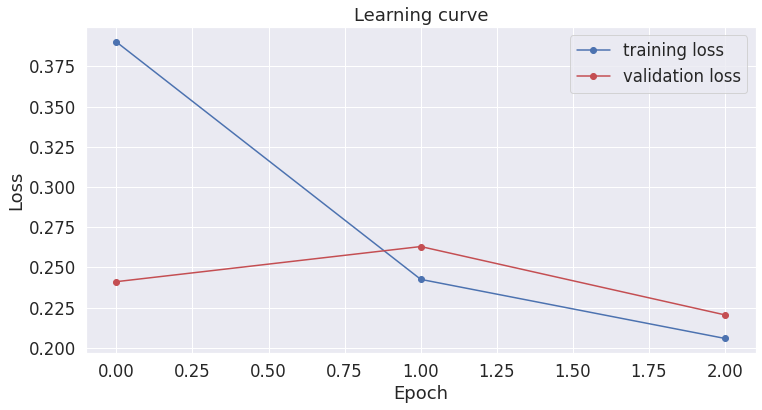

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

Let's take a look at the classification report.

In [36]:
print(classification_report(valid_tags, pred_tags))

                 precision    recall  f1-score   support

  B-corporation       0.00      0.00      0.00        15
B-creative-work       0.00      0.00      0.00        13
        B-group       0.00      0.00      0.00        30
     B-location       0.00      0.00      0.00        56
       B-person       0.00      0.00      0.00        58
      B-product       0.00      0.00      0.00        11
  I-corporation       0.00      0.00      0.00         4
I-creative-work       0.00      0.00      0.00        14
        I-group       0.00      0.00      0.00        13
     I-location       0.00      0.00      0.00        20
       I-person       0.00      0.00      0.00        25
      I-product       0.00      0.00      0.00         8
              O       0.96      0.97      0.96      6132
          [PAD]       0.00      0.00      0.00         0

       accuracy                           0.93      6399
      macro avg       0.07      0.07      0.07      6399
   weighted avg       0.92   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


This is not good. We see that the model optimizes by guessing that all tokens are not entities. There was not a single instance where the model tried to guess an entity. 

Let's take a deeper dive into the confusion matrix.

In [37]:
print(confusion_matrix(valid_tags, pred_tags))

[[   0    0    0    0    0    0    0    0    0    0    0    0   15    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0   13    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0   29    1]
 [   0    0    0    0    0    0    0    0    0    0    0    0   56    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0   58    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0   11    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    4    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0   14    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0   12    1]
 [   0    0    0    0    0    0    0    0    0    0    0    0   20    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0   20    5]
 [   0    0    0    0    0    0    0    0    0    0    0    0    8    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0 5934  198]
 [   0    0    0    0    0    0    0    0    0    0

As you can see, the model guessed (almost) every instance as not being an entiry (the second column from the right). Additionally, the model also guessed ```[PAD]``` for many of the instances, which I need to handle as well. Padding is added to all sequences less than the ```MAX_LEN``` parameter that I set, and they should not be considered predictable tags. 

## New Instances

Now we are ready to run the test data through the model. Let's see how it perofrms on a single instance. This code is also taken from the tutorial.

In [38]:
first_sent_word = df_test[df_test["s_num"] == 0]["word"]

test_sentence = ""
for i, val in first_sent_word.iteritems():
  test_sentence += val + ' '
print(test_sentence) 

test_tokenized_sentence = tokenizer.encode(test_sentence)
test_input_ids = torch.tensor([test_tokenized_sentence]).cuda()
with torch.no_grad():
    output = model(test_input_ids)
test_label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

test_tokens = tokenizer.convert_ids_to_tokens(test_input_ids.to('cpu').numpy()[0])

new_tokens, new_labels = [], []
for token, idx in zip(test_tokens, test_label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_arr[idx])
        new_tokens.append(token)
for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))

& gt ; * The soldier was killed when another avalanche hit an army barracks in the northern area of Sonmarg , said a military spokesman . 
O	[CLS]
O	&
O	gt
O	;
O	*
O	The
O	soldier
O	was
O	killed
O	when
O	another
O	avalanche
O	hit
O	an
O	army
O	barracks
O	in
O	the
O	northern
O	area
O	of
O	Sonmarg
O	,
O	said
O	a
O	military
O	spokesman
O	.
O	[SEP]


Unsurprisingly, given the model's failure to learn to correctly identify the different entities, the model has predicted that every word in the sentence is a non-entity. To remedy this, I need to return to the model's training and fix two things:

1.   Ensure that the model knows to ignore and not predict the ```[PAD]``` token.
2.   Identify why the model is failing to learn the entities and fix it.

